In [1]:
using CUDA, Random, Printf, CairoMakie, FourierFlows
using LinearAlgebra: mul!, ldiv!
include("../src/Equation_2DNS.jl")
using .Equation
parsevalsum = FourierFlows.parsevalsum

using FourierFlows
using Statistics
parsevalsum2 = FourierFlows.parsevalsum2

parsevalsum2 (generic function with 2 methods)

In [3]:
dev = GPU()
CUDA.seed!(42)

include("./namelist_benchmark.jl")

grid = TwoDGrid(dev; nx = resol, Lx = L, ny = resol, Ly = L, aliased_fraction)



TwoDimensionalGrid
  ├───────────────── Device: GPU
  ├────────────── FloatType: Float64
  ├────────── size (Lx, Ly): (6.283185307179586, 6.283185307179586)
  ├──── resolution (nx, ny): (256, 256)
  ├── grid spacing (dx, dy): (0.02454369260617026, 0.02454369260617026)
  ├───────────────── domain: x ∈ [-3.141592653589793, 3.117048960983623]
  |                          y ∈ [-3.141592653589793, 3.117048960983623]
  └─ aliased fraction: 0.3333333333333333

### Testing FourierFlows FFTW for Real Fields

For 2D Array:

In [6]:
amplCI = 1e-3
T = eltype(grid)
Dev = typeof(grid.device)
@devzeros Dev Complex{T} (size(grid.Krsq)) Fψ
@devzeros Dev T (size(grid.rfftplan)) ψ
@CUDA.allowscalar Fψ[2, 3] += amplCI * (2*CUDA.rand(T) - 1 + 1im*(2*CUDA.rand(T) - 1))
@CUDA.allowscalar Fψ[3, 2] += amplCI * (2*CUDA.rand(T)- 1 + 1im*(2*CUDA.rand(T) - 1))
@CUDA.allowscalar Fψ[2, 2] += amplCI * (2*CUDA.rand(T) - 1 + 1im*(2*CUDA.rand(T) - 1))
@CUDA.allowscalar Fψ[1, 3] += amplCI * (2*CUDA.rand(T) - 1 + 1im*(2*CUDA.rand(T) - 1))
# ensure that we got a real initial condition

ldiv!(ψ, grid.rfftplan, deepcopy(Fψ))
mul!(Fψ, grid.rfftplan, deepcopy(ψ)) 
FtestFF = deepcopy(Fψ)
# ensure that ifft(fft(x)) = x
ldiv!(ψ, grid.rfftplan, deepcopy(Fψ))
mul!(Fψ, grid.rfftplan, deepcopy(ψ)) 

isapprox(FtestFF, Fψ, rtol=1e-2)

true

In [7]:
Dev = typeof(grid.device)
T = eltype(grid)
@devzeros Dev T (size(grid.rfftplan)) u
@. u = sin(2 * grid.x) + 1/2 * cos(5 * grid.y)
cpy  = deepcopy(u)
@devzeros Dev Complex{T} (size(grid.Krsq)) Fu

# same on a random x-function
mul!(Fu, grid.rfftplan, deepcopy(u)) 
ldiv!(u, grid.rfftplan, deepcopy(Fu))
isapprox(u, cpy, rtol=1e-8)

true

# Test dérivées grid


In [17]:
Dev = typeof(grid.device)
T = eltype(grid)
@devzeros Dev T (size(grid.rfftplan)) u
@devzeros Dev T (size(grid.rfftplan)) uprime
@. u = sin(2 * grid.x) + 0* cos(5 * grid.y)
@. uprime = 2*cos(2 * grid.x) + 0* cos(5 * grid.y)

@devzeros Dev Complex{T} (size(grid.Krsq)) Fu

mul!(Fu, grid.rfftplan, deepcopy(u)) 

ldiv!(u, grid.rfftplan, @. im * grid.kr * Fu) # scratch


isapprox(u, uprime, rtol=1e-8)



true

## Test mean and parseval_sum 

#### Note on Normalization Differences Between MATLAB and Julia Code

There is a difference in normalization conventions between the MATLAB and Julia implementations:

- **In the MATLAB code**:
  - The Fourier Transform (FT) is computed as:
    \[
    $\text{FT} = \frac{\sum \sum \left( X_{ij} \, e^{i \dots} \right)}{N^2}$
    \]
  - The Inverse Fourier Transform (IFT) is computed as:
    \[
    $\text{IFT} = \sum \sum \left( \hat{X}_{ij} \, e^{i \dots} \right)$
    \]

- **In the JULIA code**:
  - The usual convention applies: the prefactor 1/N2 is in front of the inverse fourier transform, no prefactor on the direct fft. meaning that energy(Fmat) = $1/L^2 \int f dx dy$ is like parseval sum for domain of size 1x1, or is like mean in physical space (expected). mean power input $\epsilon$ is computed with mean imposed power spectrum. We choose to switch fft convention to the one used in matlab ? déjà on corrige le bilan d'energie avant d'essayer quoi que ce soit.

- **Parseval's Theorem**:
  - Parseval's theorem in MATLAB code does not require a prefactor when calculated as the sum of the Fourier coefficients.
  - However, when summing coefficients, remember:
    - Each frequency component should be counted twice, reflecting the structure of the real FFT (`rfft`) where each coefficient is paired with its conjugate.

This normalization discrepancy should be kept in mind when interpreting results between MATLAB and Julia implementations.

In [27]:

# we test with sin^2 integrated over (2π,2π)

Dev = typeof(grid.device)
T = eltype(grid)
@devzeros Dev T (size(grid.rfftplan)) sin2
@. sin2 = sin(grid.x)^2 + 0* cos(5 * grid.y)
@devzeros Dev Complex{T} (size(grid.Krsq)) Fsin2
# mean with Statistics.jl
ref =mean(Array(sin2))

@devzeros Dev T (size(grid.rfftplan)) u
@devzeros Dev Complex{T} (size(grid.Krsq)) Fu

@. u =  sin(grid.x) + 0* cos(5 * grid.y)

mul!(Fu, grid.rfftplan, deepcopy(u)) 
# test energy fn, should be a mismatch of 1/N4 due to difference in normalization btw matlab and julia code (already corrected in Equation_2DNS)
res = Equation.energy(Array(Fu), Array(grid.Krsq), 0)
println(res)
isapprox(ref, res, rtol=1e-8)


0.5


true

### Testing advection term (non-linear ifft) 

In [28]:
@. u = sin(2 * grid.x) + 0* cos(5 * grid.y)
@. uprime = 2*cos(2 * grid.x) + 0* cos(5 * grid.y)

udxu = @. u * uprime
cpy = deepcopy(udxu)
@devzeros Dev Complex{T} (size(grid.Krsq)) Fudxu

mul!(Fudxu, grid.rfftplan, deepcopy(udxu)) 
ldiv!(udxu, grid.rfftplan, Fudxu) # scratch

isapprox(cpy, udxu, rtol=1e-8)

true

### Testing the amplitude of the Kolmogorov forcing 

In [ ]:
# τf * sin(kf y) with τf = 1
resol = size(grid.rfftplan,1)
Dev = typeof(grid.device)
T = eltype(grid)
@devzeros Dev T (size(grid.rfftplan)) forcing
@devzeros Dev Complex{T} (size(grid.Krsq)) Fforcing

@. forcing = transpose(sin.(kf * transpose(grid.y))) 
mul!(Fforcing, grid.rfftplan, deepcopy(forcing)) 

# implemented as 
@devzeros Dev T (size(grid.rfftplan)) fh
@devzeros Dev Complex{T} (size(grid.Krsq)) Fh
@CUDA.allowscalar Fh[1, kf + 1] = 1/2;
@CUDA.allowscalar Fh[1, end - kf + 1] = 1/2;
@. Fh *= resol^2 
ldiv!(fh, grid.rfftplan, deepcopy(Fh)) # scratch

isapprox(Fforcing, Fh)



false

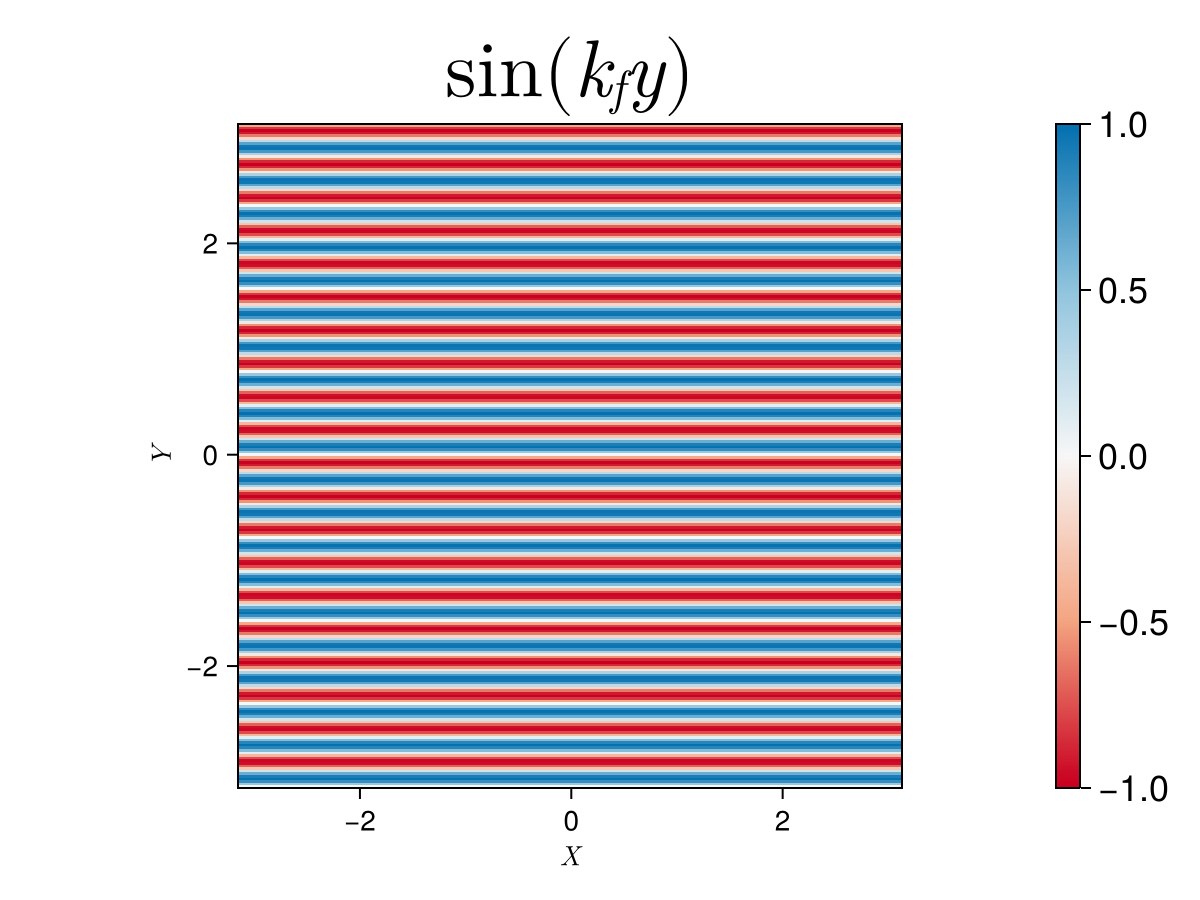

CairoMakie.Screen{IMAGE}


In [32]:
fig = Figure()
ax1 = Axis(fig[1, 1], 
    title = L"$\sin(k_f y)$", 
    titlesize = 40,
    xlabel = L"$X$", 
    ylabel = L"$Y$",
    aspect = DataAspect()
)
hm = heatmap!(ax1, 
    Array(grid.x), Array(grid.y), transpose(Array(forcing)), 
    colormap = :RdBu_5,                   
    colorrange = extrema(Array(forcing))
    )
Colorbar(fig[1, 2], hm, ticklabelsize = 18)
display(fig)

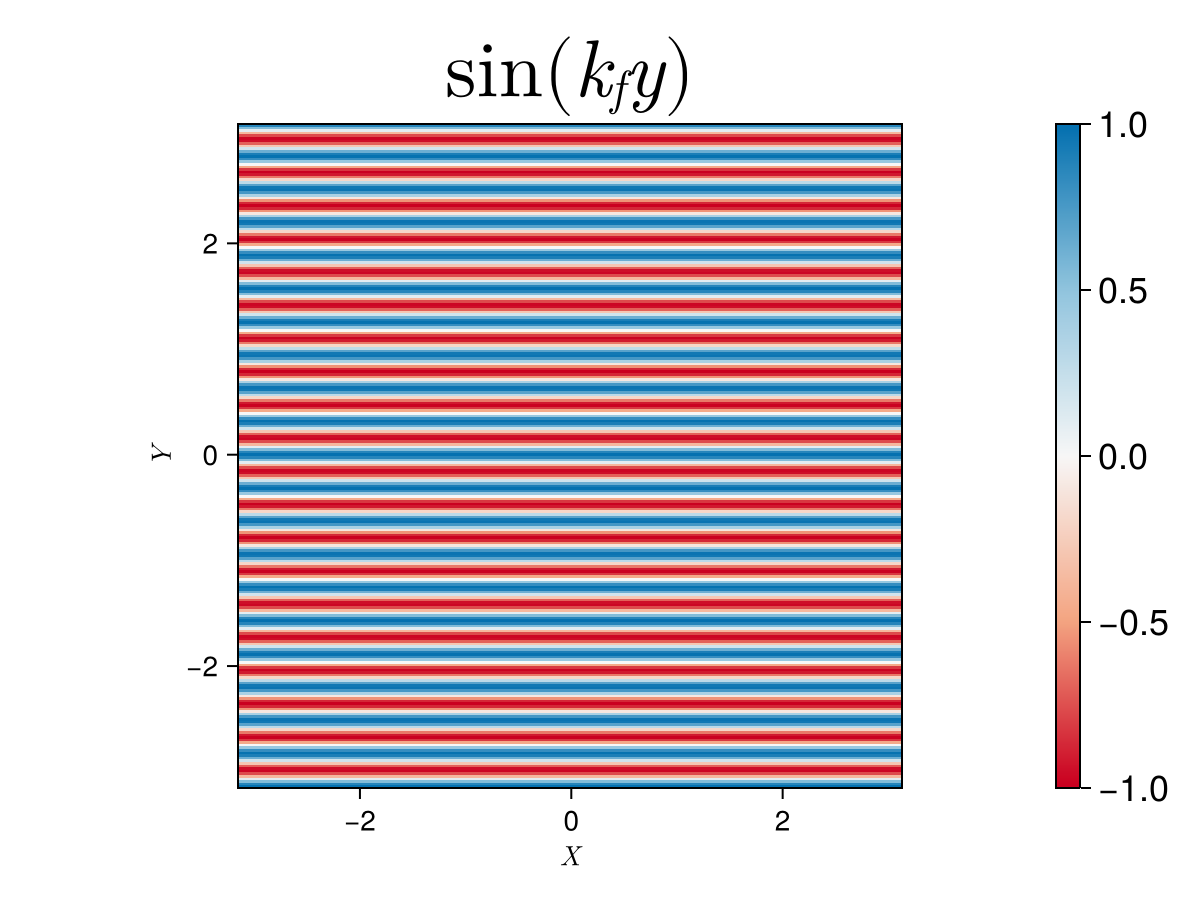

CairoMakie.Screen{IMAGE}


In [33]:
fig = Figure()
ax1 = Axis(fig[1, 1], 
    title = L"$\sin(k_f y)$", 
    titlesize = 40,
    xlabel = L"$X$", 
    ylabel = L"$Y$",
    aspect = DataAspect()
)
hm = heatmap!(ax1, 
    Array(grid.x), Array(grid.y), Array(fh), 
    colormap = :RdBu_5,                   
    colorrange = extrema(Array(fh))
    )
Colorbar(fig[1, 2], hm, ticklabelsize = 18)
display(fig)